#  Forecasting taxi orders.

The company has collected historical data on taxi orders at airports. To attract more drivers during peak demand periods, it is necessary to forecast the number of taxi orders for the next hour.

The RMSE (Root Mean Square Error) value on the test dataset should not exceed 48.

We need to:

Load the data and resample it to hourly intervals.
Analyze the data.
Train different models with various hyperparameters. Create a test dataset comprising 10% of the original data.
Evaluate the data on the test dataset.

## Import libraries

In [1]:
!pip install -U catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

RANDOM_STATE = 42

## Upload data

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
df.index.is_monotonic_increasing

True

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

Let's convert the frequency and resample the time series

In [7]:
df = df.resample('1H').sum()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
display(df.head(1)), display(df.tail(1))

,num_orders
datetime,
2018-03-01,124


,num_orders
datetime,
2018-08-31 23:00:00,205


(None, None)

We have data on taxi loading in for every hour of every day from 2018-03-01 to 2018-08-31. Omissions weren't detected, no duplicates were found among the indexes. Let's move on to the analysis.

## Analysis

Let's look at the distribution of taxis on the graph for any three days.

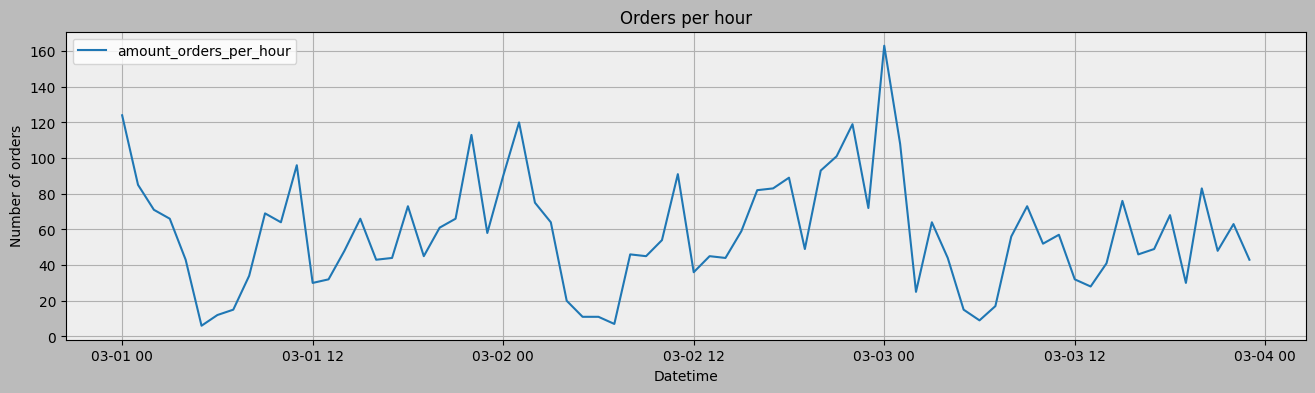

In [10]:
fig = plt.figure(figsize=(16, 4), facecolor='#bbb')
ax = fig.add_subplot(facecolor='#eee')
ax.plot(df['2018-03-01':'2018-03-03'].resample('1h').sum(), label='amount_orders_per_hour')
plt.grid()
plt.title('Orders per hour')
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.legend(loc='upper left');

Let's add smoothing in 3, 6 and 12 hours.

<ipython-input-11-5655f6f9061c>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(311, facecolor='#eee')
<ipython-input-11-5655f6f9061c>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(312, facecolor='#eee')
<ipython-input-11-5655f6f9061c>:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(313, facecolor='#eee')


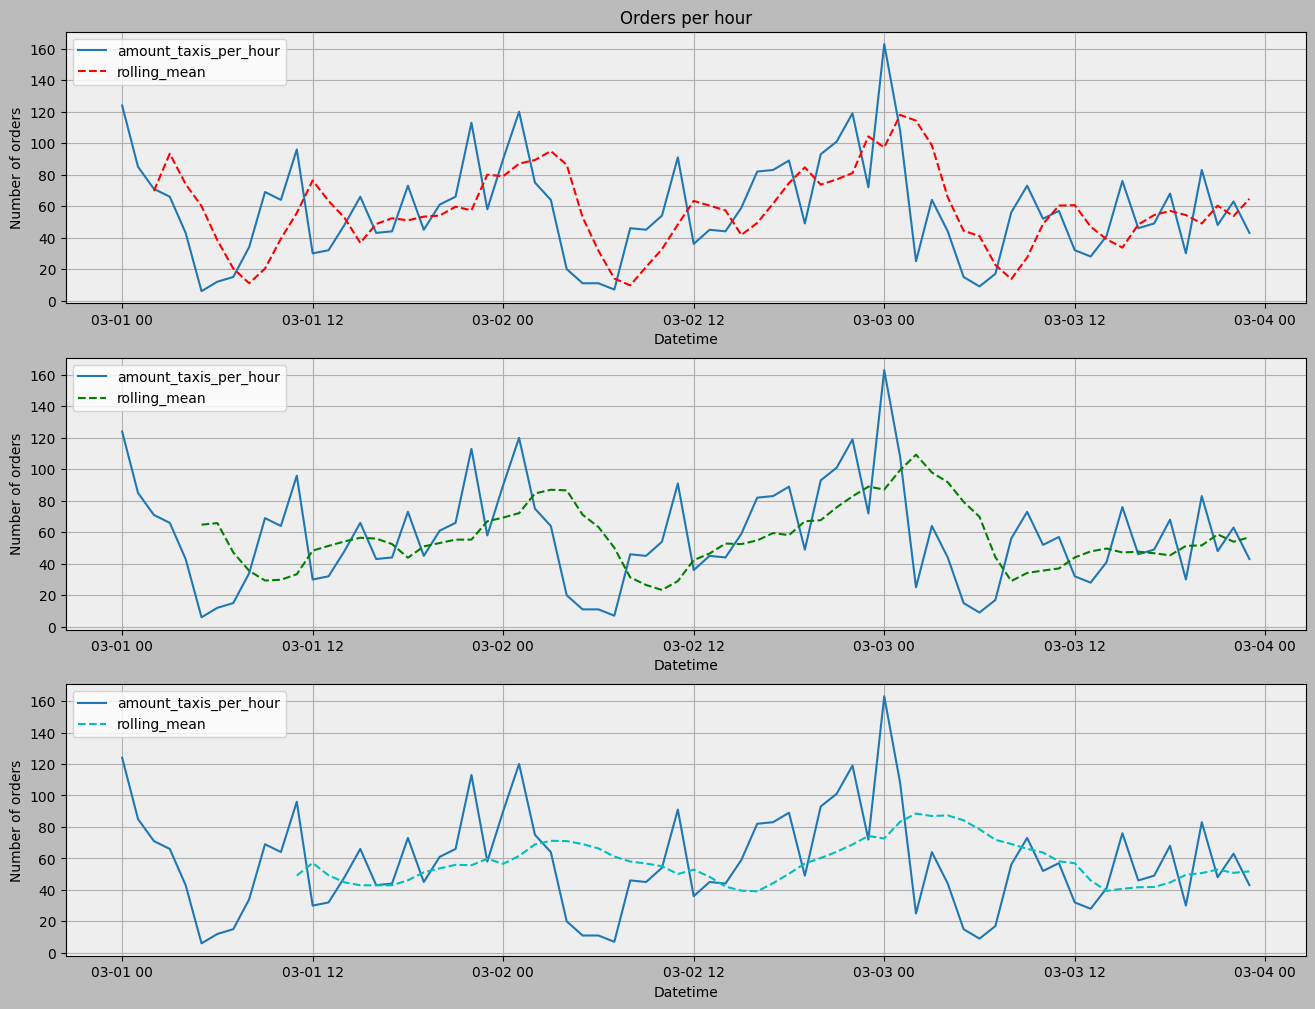

In [11]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(16, 12)
fig.set_facecolor('#bbb')


ax1 = plt.subplot(311, facecolor='#eee')
plt.plot(df['2018-03-01':'2018-03-03'].resample('1h').sum(), label='amount_taxis_per_hour')
plt.plot(df['2018-03-01':'2018-03-03'].shift(1).resample('1h').sum().rolling(3).mean(), 'r--', label='rolling_mean')
plt.grid()
plt.title('Orders per hour')
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.legend(loc='upper left')

ax2 = plt.subplot(312, facecolor='#eee')
plt.plot(df['2018-03-01':'2018-03-03'].resample('1h').sum(), label='amount_taxis_per_hour')
plt.plot(df['2018-03-01':'2018-03-03'].shift(1).resample('1h').sum().rolling(6).mean(), 'g--', label='rolling_mean')
plt.grid()
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.legend(loc='upper left')

ax2 = plt.subplot(313, facecolor='#eee')
plt.plot(df['2018-03-01':'2018-03-03'].resample('1h').sum(), label='amount_taxis_per_hour')
plt.plot(df['2018-03-01':'2018-03-03'].shift(1).resample('1h').sum().rolling(12).mean(), 'c--', label='rolling_mean')
plt.grid()
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.legend(loc='upper left');

It can be seen from the graphs that 3 hours gives weak smoothing, 12 is too strong, and 6 is optimal. Let's check trends and seasonality.

<ipython-input-12-b5491c652217>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(311, facecolor='#eee')
<ipython-input-12-b5491c652217>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(312, facecolor='#eee')
<ipython-input-12-b5491c652217>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(313, facecolor='#eee')


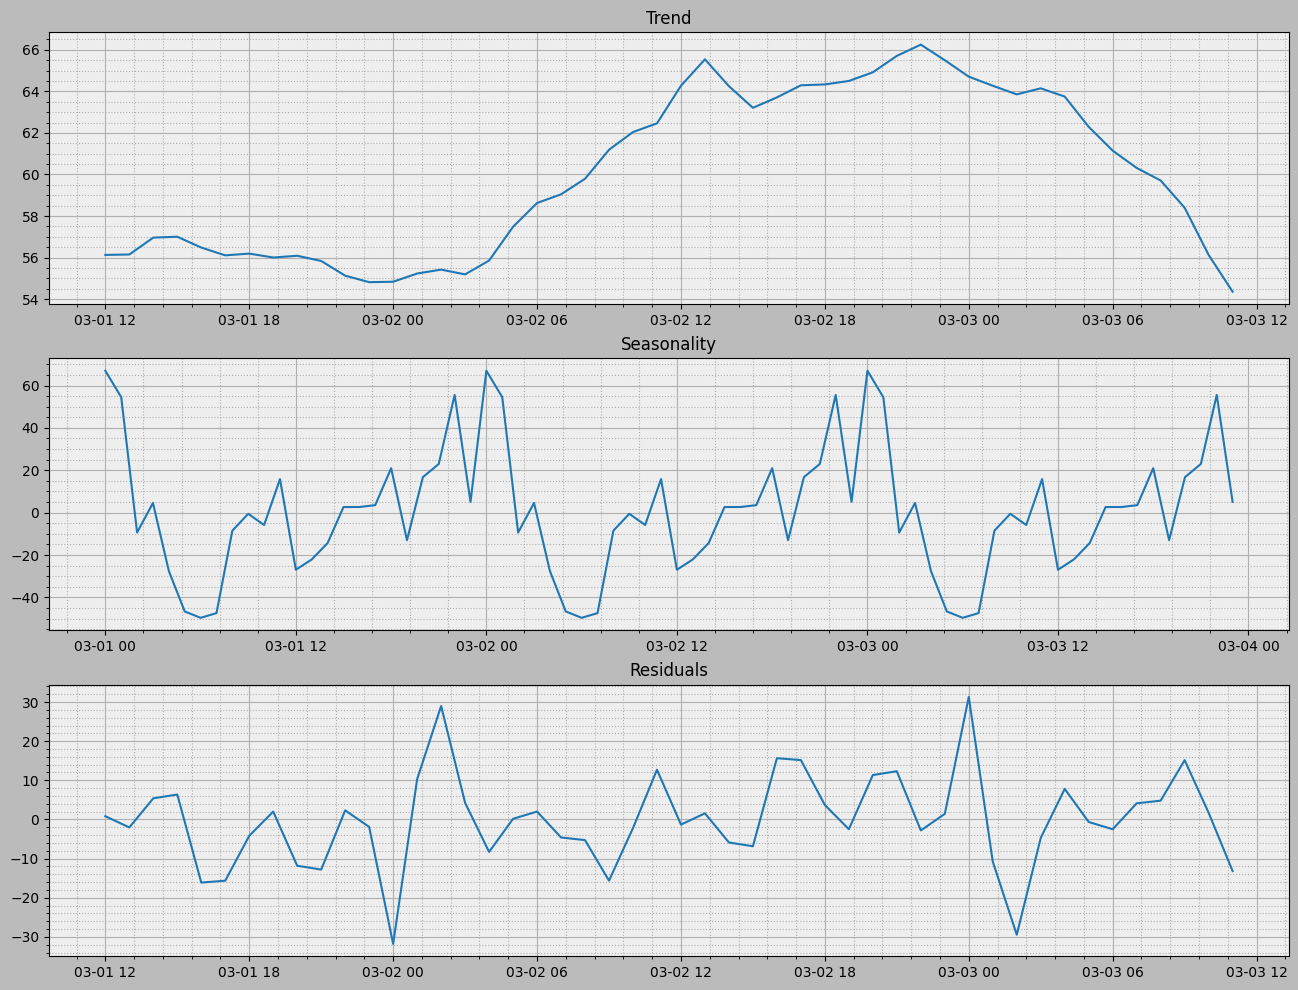

In [12]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-03'])
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(16, 12)
fig.set_facecolor('#bbb')

ax1 = plt.subplot(311, facecolor='#eee')
plt.plot(decomposed.trend)
plt.minorticks_on()
plt.title('Trend')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

ax2 = plt.subplot(312, facecolor='#eee')
plt.plot(decomposed.seasonal)
plt.minorticks_on()
plt.title('Seasonality')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

ax3 = plt.subplot(313, facecolor='#eee')
plt.plot(decomposed.resid)
plt.minorticks_on()
plt.title('Residuals')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':');

There is definitely seasonality within a day, there are 4 peak hours, and the trend is also changing a lot. Let's check the seasonality within a week.

<ipython-input-13-499c3ca0a75f>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(311, facecolor='#eee')
<ipython-input-13-499c3ca0a75f>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(312, facecolor='#eee')
<ipython-input-13-499c3ca0a75f>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(313, facecolor='#eee')


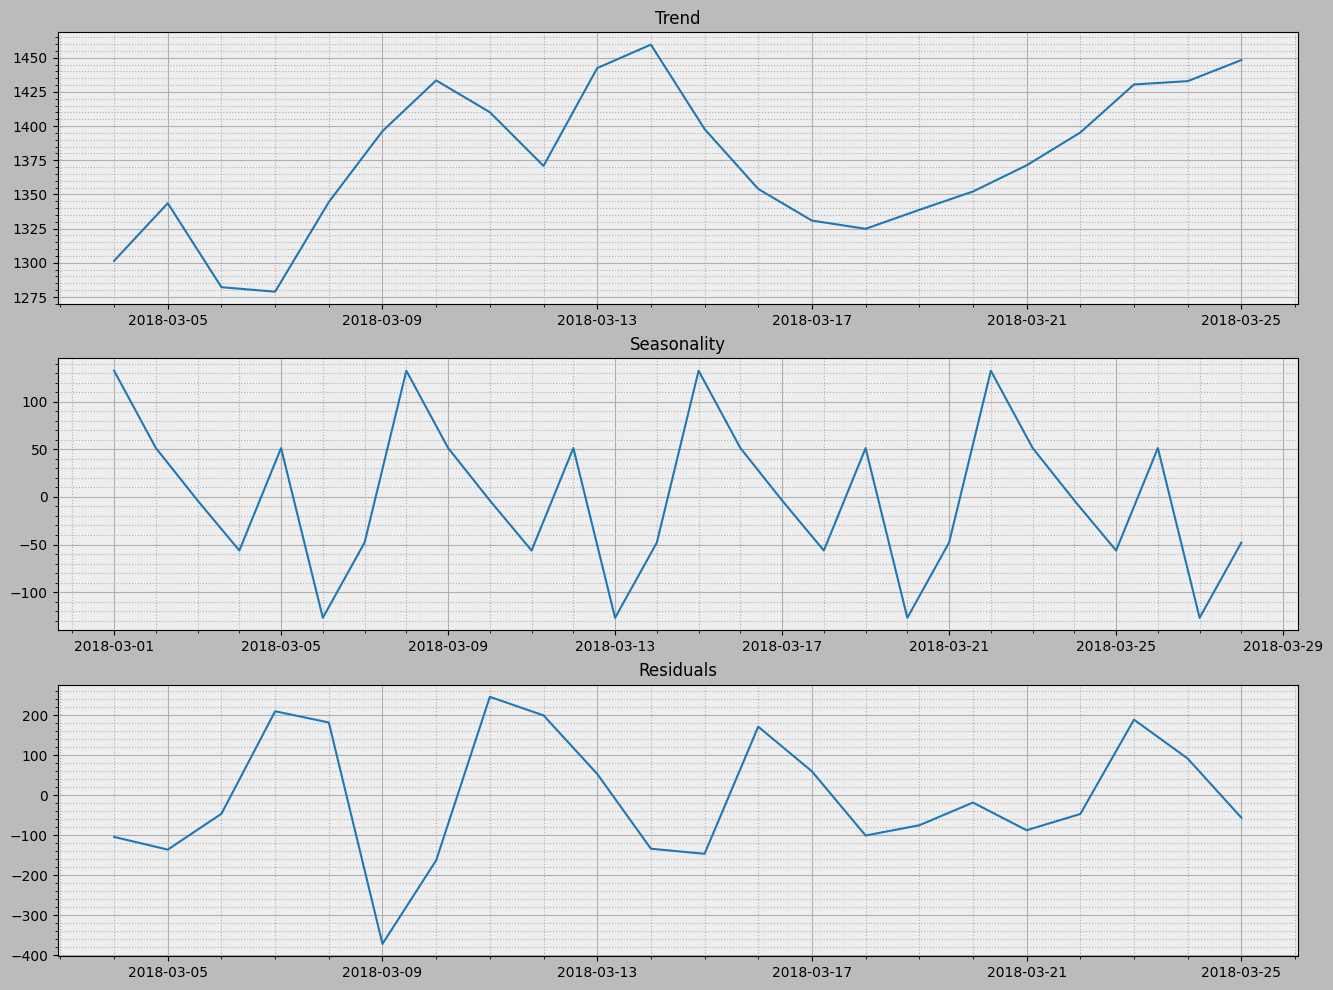

In [13]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-28'].resample('1D').sum())
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(16, 12)
fig.set_facecolor('#bbb')

ax1 = plt.subplot(311, facecolor='#eee')
plt.plot(decomposed.trend)
plt.minorticks_on()
plt.title('Trend')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

ax2 = plt.subplot(312, facecolor='#eee')
plt.plot(decomposed.seasonal)
plt.minorticks_on()
plt.title('Seasonality')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

ax3 = plt.subplot(313, facecolor='#eee')
plt.plot(decomposed.resid)
plt.minorticks_on()
plt.title('Residuals')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':');

There is also seasonality within the week and the trend is changing rapidly, so we will take not only the previous hour as signs, but also the same hour of the previous day and the same hour of the same day of the week of the previous week.

## Preparation of features

Let's write a function to create new features

In [14]:
def get_features(data):
    data['dayofweek'] = data.index.dayofweek
    
    data['lag_1h'] = data['num_orders'].shift(1)
    data['lag_1d'] = data['num_orders'].shift(24)
    data['lag_1w'] = data['num_orders'].shift(168)
    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(3).mean()

The function is ready, we will create new features

In [15]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [16]:
get_features(df)

In [17]:
df.head()

,num_orders,dayofweek,lag_1h,lag_1d,lag_1w,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,NaN,NaN,93.333333
2018-03-01 04:00:00,43,3,66.0,NaN,NaN,74.000000


New features have been obtained, we will remove the empty values and prepare samples for training.

In [18]:
df = df.dropna()

In [19]:
df.head()

,num_orders,dayofweek,lag_1h,lag_1d,lag_1w,rolling_mean
datetime,,,,,,
2018-03-08 00:00:00,143,3,94.0,100.0,124.0,109.666667
2018-03-08 01:00:00,78,3,143.0,121.0,85.0,121.333333
2018-03-08 02:00:00,65,3,78.0,24.0,71.0,105.000000
2018-03-08 03:00:00,68,3,65.0,66.0,66.0,95.333333
2018-03-08 04:00:00,60,3,68.0,73.0,43.0,70.333333


In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3823, 5), (3823,), (425, 5), (425,))

## Training models

Let's create cross-validator with 9 splits.

In [22]:
cv = TimeSeriesSplit(n_splits=9)

### Ridge

In [23]:
params_rd = {'alpha': range(1, 10)}
rd = Ridge(random_state=RANDOM_STATE)
grid_rd = GridSearchCV(rd, param_grid=params_rd, scoring='neg_root_mean_squared_error',
                       cv=cv, n_jobs=-1)
grid_rd.fit(X_train, y_train)

best_param_rd = pd.DataFrame(grid_rd.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_rd = best_param_rd[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_rd

,mean_fit_time,mean_score_time,params,mean_test_score
8,0.016124,0.011936,{'alpha': 9},-22.903915


### RandomForestRegressor

In [24]:
params_rfr = {'n_estimators': [100, 200, 300], 
              'max_depth':[5, 7, 9]}
rfr = RandomForestRegressor(random_state=RANDOM_STATE)
grid_rfr = GridSearchCV(rfr, param_grid=params_rfr, scoring='neg_root_mean_squared_error', 
                   cv=cv, n_jobs=-1)
grid_rfr.fit(X_train, y_train)

best_param_rfr = pd.DataFrame(grid_rfr.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_rfr = best_param_rfr[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_rfr

,mean_fit_time,mean_score_time,params,mean_test_score
2,2.594444,0.078356,"{'max_depth': 5, 'n_estimators': 300}",-23.24832


### CatBoostRegressor

In [25]:
params_cbr = {'n_estimators': [100, 200, 300],
              'max_depth':[5, 7, 9],
              'learning_rate': [0.1, 0.3]}
cbr = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
grid_cbr = GridSearchCV(cbr, param_grid=params_cbr, scoring='neg_root_mean_squared_error', 
                   cv=cv, n_jobs=-1)
grid_cbr.fit(X_train, y_train)
best_param_cbr = pd.DataFrame(grid_cbr.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_cbr = best_param_cbr[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_cbr

,mean_fit_time,mean_score_time,params,mean_test_score
0,0.233903,0.002567,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-22.932174


### XGBRegressor

In [26]:
params_xgbr = {'n_estimators': [100, 200, 300],
               'max_depth':[5, 7, 9],
               'learning_rate': [0.1, 0.3]}
xgbr = XGBRegressor(random_state=RANDOM_STATE)
grid_xgbr = GridSearchCV(xgbr, param_grid=params_xgbr, scoring='neg_root_mean_squared_error', 
                         cv=cv, n_jobs=-1)
grid_xgbr.fit(X_train, y_train)

best_param_xgbr = pd.DataFrame(grid_xgbr.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_xgbr = best_param_xgbr[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_xgbr

,mean_fit_time,mean_score_time,params,mean_test_score
0,0.279948,0.007669,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-24.354672


## Testing

In [27]:
result = pd.concat([best_param_rd, best_param_rfr, best_param_cbr, best_param_xgbr], ignore_index=True, axis=0)
result.index=['Ridge', 'RandomForestRegressor','CatBoostRegressor', 'XGBRegressor']
result.mean_test_score = result.mean_test_score * -1
result

,mean_fit_time,mean_score_time,params,mean_test_score
Ridge,0.016124,0.011936,{'alpha': 9},22.903915
RandomForestRegressor,2.594444,0.078356,"{'max_depth': 5, 'n_estimators': 300}",23.248320
CatBoostRegressor,0.233903,0.002567,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",22.932174
XGBRegressor,0.279948,0.007669,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",24.354672


The Ridge model has achieved the best RMSE, along with the most favorable training and prediction time. Let's examine the coefficient values report for each feature.

In [28]:
pd.DataFrame({'Feature': X_train.columns,
              'Importance': grid_rd.best_estimator_.coef_})

,Feature,Importance
0,dayofweek,-0.248099
1,lag_1h,0.119165
2,lag_1d,0.241777
3,lag_1w,0.555909
4,rolling_mean,0.061976


The data for the same day last week has the highest coefficient. Let's test the model on a test sample and look at the error.

In [29]:
mean_squared_error(y_test, grid_rd.predict(X_test), squared=False)

35.85849456135816

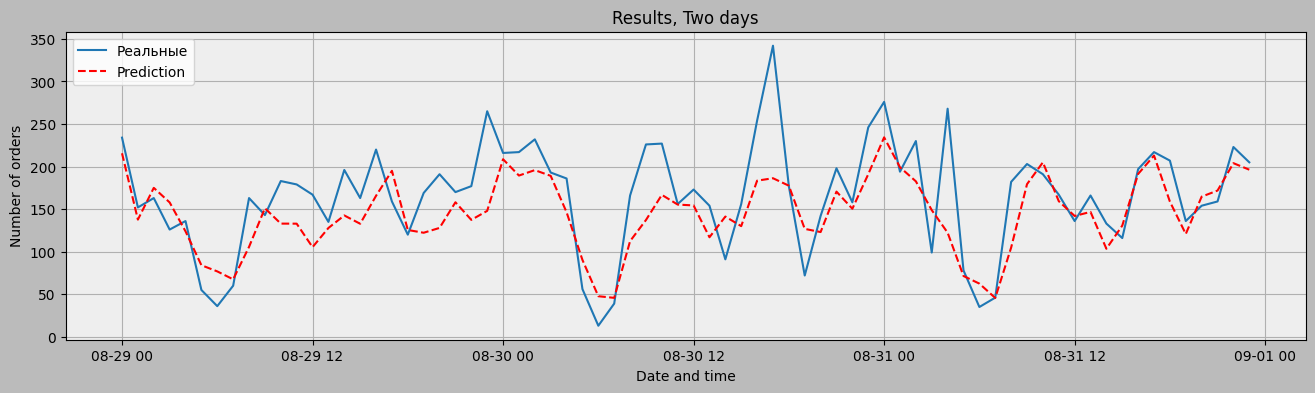

In [30]:
fig = plt.figure(figsize=(16, 4), facecolor='#bbb')
ax = fig.add_subplot(facecolor='#eee')

plt.plot(y_test['2018-08-29':'2018-08-31'], label='Реальные')
plt.plot(pd.Series(grid_rd.predict(X_test), index = y_test.index)['2018-08-29':'2018-08-31'], 'r--', 
         label='Prediction')
plt.grid()
plt.title('Results, Two days')
plt.xlabel('Date and time')
plt.ylabel('Number of orders')
plt.legend(loc='upper left');

## Conclusion
We conducted a time series analysis using data on the number of orders after preprocessing the data. Based on the analysis, we identified daily and weekly seasonality patterns and observed a changing trend. We added the necessary features for training. Four models were tested: Ridge, RandomForestRegressor, CatBoostRegressor and XGBRegressor. After training, we determined the best model to be Ridge. The testing resulted in an RMSE of 35.85, which exceeds the specified threshold. On the graph, it is evident that there are some discrepancies in certain hours, but they do not exhibit any particular pattern.